## Introduction
In this assignment, you will learn how to build a language model from scratch and use the model to generate new text.
You will also see how training a language model helps you learn word representation.

Note: 
- Plagiarism will result in 0 mark.
- The following template shows how your code should look like. You are free to add more functions, change the parameters. You are not allowed to use existing implementations.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/RNN

/content/drive/MyDrive/Colab Notebooks/RNN


In [ ]:
import torch
import torch.nn as nn
import torch.autograd as ag
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim
import math

## Recurrent Neural Network (5 points)
To begin, you have to implement the vanila RNN in Pytorch.

Recall the formula for vanila RNN:
        \begin{eqnarray}
        h_t & = & \sigma(W_h h_{t-1} + W_x x_t + b_1) \\
        y_t & = & \phi(W_y h_t + b_2)
        \end{eqnarray}
where $\sigma$ is the usually the sigmoid activation function and $\phi$ is usually the softmax function.

Hints:
For RNNLM, the input is a squence of word_id, e.g. [10, 8, 5, 2, 101, 23]. You have to convert each word_id to an embedding vector. To implement this, you can use the `torch.nn.Embedding` class.

In [ ]:
def create_emb_layer(num_embeddings, embedding_dim, non_trainable = False):
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    if non_trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer

In [ ]:
class VanilaRNNLM(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_outputs, vocab, sigma='sigmoid', phi='softmax'):
        """
        Construct a vanila RNN. 
        
        Params:
        n_inputs: number of input neurons
        n_hiddens: number of hidden neurons
        n_outputs: number of output neurons
        vocab: a dictionary of the form {word: word_id}
        sigma: activation function for hidden layer
        phi: output function
        """
        super(VanilaRNNLM, self).__init__()

        n_vocab = len(vocab)
        self.n_hiddens = n_hiddens  

        self.embedding = nn.Embedding(n_vocab, n_inputs)

        self.in2hid = nn.Linear(n_inputs , n_hiddens)
        self.hid2out = nn.Linear(n_hiddens , n_outputs)
        self.hid2hid = nn.Linear(n_hiddens, n_hiddens)
            
    def forward(self, xs, h0):
        """
        Params:
        xs: the input sequence [x_1, x_2, ..., x_n]. x_i is the id of the i-th word in the sequence. 
            For example, xs = [1, 3, 11, 6, 8, 2]
        h0: the initial hidden state
        
        Returns: (ys, hs) where
        ys = [y_1, y_2, ..., y_n] and
        hs = [h_1, h_2, ..., h_n]
        """
        embed = self.embedding(xs)
        
        hidden = self.in2hid(embed) + self.hid2hid(h0) 
        hidden_state = torch.sigmoid(hidden)
        output = self.hid2out(hidden_state)
        return output, hidden_state
    
    def init_state(self, batch_size):
        return torch.zeros(batch_size, self.n_hiddens)

In [ ]:
## RNN with layer nn.RNN
class RNNLM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, vocab):
        super(RNNLM, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.encoder = nn.Embedding(len(vocab), input_size)
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, xs, h0):
        embed = self.encoder(xs)

        out, hidden = self.rnn(embed, h0)
        # print('out',out.size())
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_state(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

Vanila RNN suffers from the gradient vanishing/exploding problem. Your next task is to implement a more sophisticated RNN that is more robust to gradient vanishing/exploding.

In [ ]:
class LSTM(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_outputs, vocab):
        """
        Construct a fancy RNN, this could be LSTM, GRU, or your own invention.
        
        Params:
        n_inputs: number of input neurons
        n_hiddens: number of hidden neurons
        n_outputs: number of output neurons
        vocab: a dictionary {word: word_id}
        sigma: activation function for hidden layer
        phi: output function
        """
        
        super(LSTM, self).__init__()

        
        self.n_inputs = n_inputs
        self.n_hiddens = n_hiddens
        self.n_outputs = n_outputs
        ## Embedding
        self.embedding = nn.Embedding(len(vocab), self.n_inputs)

        ##Cell state
        self.in2hid = nn.Linear(n_inputs, n_hiddens)
        self.hid2hid = nn.Linear(n_hiddens, n_hiddens)

        ##Forget gate
        self.in2hid_f = nn.Linear(n_inputs, n_hiddens)
        self.hid2hid_f = nn.Linear(n_hiddens, n_hiddens)

        ##Input gate
        self.in2hid_i = nn.Linear(n_inputs, n_hiddens)
        self.hid2hid_i = nn.Linear(n_hiddens, n_hiddens)

        ##Output gate
        self.in2hid_o = nn.Linear(n_inputs, n_hiddens)
        self.hid2hid_o = nn.Linear(n_hiddens, n_hiddens)

        ##Hidden to output
        self.hid2out = nn.Linear(n_hiddens, n_outputs)
    
    def forward(self, xs, h0):
        prev_hidden, prev_cell = h0

        embed = self.embedding(xs)
        
        forget_gate = torch.sigmoid(self.in2hid_f(embed) + self.hid2hid_f(prev_hidden))
        input_gate = torch.sigmoid(self.in2hid_i(embed) + self.hid2hid_i(prev_hidden))
        output_gate = torch.sigmoid(self.in2hid_o(embed) + self.hid2hid_o(prev_hidden))
        
        new_cell_content = torch.tanh(self.in2hid(embed) + self.hid2hid(prev_hidden))
        cell_state = (forget_gate * prev_cell) + (input_gate * new_cell_content)
        hidden_state = output_gate * torch.tanh(cell_state)
        
        output = self.hid2out(hidden_state)
        
        return output, (hidden_state, cell_state)

    def init_state(self, batch_size):
        hidden = torch.zeros((batch_size, self.n_hiddens), requires_grad = True)
        cell = torch.zeros((batch_size, self.n_hiddens), requires_grad = True)

        return (hidden, cell)

In [ ]:
# LSTM with nn.lstm
class FancyRNNLM(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_outputs, n_layers, vocab, sigma='sigmoid', phi='softmax'):
        """
        Construct a fancy RNN, this could be LSTM, GRU, or your own invention.
        
        Params:
        n_inputs: number of input neurons
        n_hiddens: number of hidden neurons
        n_outputs: number of output neurons
        vocab: a dictionary {word: word_id}
        sigma: activation function for hidden layer
        phi: output function
        """
        super(FancyRNNLM, self).__init__()
        self.n_hiddens = n_hiddens
        self.n_inputs = n_inputs
        self.n_layers = n_layers
        n_vocab = len(vocab)

        self.embedding = nn.Embedding(n_vocab, self.n_inputs)
        self.lstm = nn.LSTM(input_size=self.n_inputs, hidden_size=self.n_hiddens, num_layers= self.n_layers, batch_first=True)
        self.fc = nn.Linear(self.n_hiddens, n_vocab)
    
    def forward(self, xs, h0):
        embed = self.embedding(xs)
        output, hidden = self.lstm(embed, h0)
        output = output.contiguous().view(-1, self.n_hiddens)
        logits = self.fc(output)

        return logits, hidden
        
    def init_state(self, batch_size):
        return (torch.zeros(self.n_layers, batch_size, self.n_hiddens),
                torch.zeros(self.n_layers, batch_size, self.n_hiddens))

## Language Modeling with RNN (4 points)
The next step is to use our RNNs in some real world tasks. One of the most common application of RNN is language modeling.

### Data
For this assignment, we will use text data from Wikipedia. To start, download the data from this website:

https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip

Some information about this dataset can be found here:

https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/



In [ ]:
# !unzip wikitext-103-v1.zip

In [ ]:
from pathlib import Path
import re

In [ ]:
from torch.utils.data import Dataset
from pathlib import Path
from collections import Counter

class Dataset(Dataset):
    def __init__(self,sequence_length):
        self.sequence_length = sequence_length
        self.words = self.load_words()
        self.words_test = self.load_words_test()
        self.words_corpus = self.words + self.words_test

        self.vocab = self.get_uniq_words()
        self.word2idx = {word:ind for ind,word in enumerate (self.vocab)}
        self.idx2word = {ind:word for ind,word in enumerate (self.vocab)}
        
        self.words_indexes = [self.word2idx[w] for w in self.words]
        self.words_indexes_test = [self.word2idx[w] for w in self.words_test]
    
    def load_words(self):
        data = Path('wikitext-103/wiki.train.tokens').read_text()
        data = data.lower().replace('\n','<eos>')
        return data.split(' ')[:10000000]
    
    def load_words_test(self):
        data = Path('wikitext-103/wiki.test.tokens').read_text()
        data = data.lower().replace('\n','<eos>')
        return data.split(' ')

    def get_uniq_words(self):
        vocab = Counter(self.words_corpus)
        return sorted(vocab, key=vocab.get, reverse= True)
    
    def __len__(self):
        n_batch = (len(self.words_indexes) / self.sequence_length) // 20 
        # return int(len(self.words_indexes) / self.sequence_length - 2)
        return int(n_batch * 20)
        
    def __getitem__(self,index):
        seq_len = min(self.sequence_length, len(self.words_indexes) - 1 - index*self.sequence_length)
        return (
            torch.tensor(self.words_indexes[index*seq_len:index*seq_len+seq_len]),
            torch.tensor(self.words_indexes[index*seq_len+1:index*seq_len+seq_len+1])
        )
        

In [ ]:
dataset = Dataset(sequence_length = 30)

In [ ]:
vocab = dataset.vocab
vocab_size = len(vocab)

In [ ]:
print(vocab_size)
print(len(dataset.words))
print(len(dataset.words_indexes_test))

116377
10000000
245570


In [ ]:
print(' '.join(dataset.words[:1000]).replace('<eos>','\n'))
# print(vocab_size)
# print(vocab[:10])

 
 = valkyria chronicles iii = 
 
 senjō no valkyria 3 : <unk> chronicles ( japanese : 戦場のヴァルキュリア3 , lit . valkyria of the battlefield 3 ) , commonly referred to as valkyria chronicles iii outside japan , is a tactical role @-@ playing video game developed by sega and media.vision for the playstation portable . released in january 2011 in japan , it is the third game in the valkyria series . employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " nameless " , a penal military unit serving the nation of gallia during the second europan war who perform secret black operations and are pitted against the imperial unit " <unk> raven " . 
 the game began development in 2010 , carrying over a large portion of the work done on valkyria chronicles ii . while it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomer

In [ ]:
# test data loader
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=20, drop_last = True)
print(len(dataloader.dataset))
print(len(dataloader))

333320
16666


### Training a LM with RNN
Write the code to train RNNLMs with the VanilaRNNLM and FancyRNNLM classes above. Train 1 instance of VanilaRNNLM and 1 instance of FancyRNNLM

In [ ]:
n_inputs = 22
n_hiddens = 512
n_outputs = len(vocab)


In [ ]:
RNNvanila = VanilaRNNLM(n_inputs, n_hiddens, n_outputs, vocab)
print(RNNvanila)

VanilaRNNLM(
  (embedding): Embedding(116377, 22)
  (in2hid): Linear(in_features=22, out_features=512, bias=True)
  (hid2out): Linear(in_features=512, out_features=116377, bias=True)
  (hid2hid): Linear(in_features=512, out_features=512, bias=True)
)


In [ ]:
lstm = LSTM(n_inputs,n_hiddens,n_outputs, vocab)
print(lstm)

LSTM(
  (embedding): Embedding(116377, 22)
  (in2hid): Linear(in_features=22, out_features=512, bias=True)
  (hid2hid): Linear(in_features=512, out_features=512, bias=True)
  (in2hid_f): Linear(in_features=22, out_features=512, bias=True)
  (hid2hid_f): Linear(in_features=512, out_features=512, bias=True)
  (in2hid_i): Linear(in_features=22, out_features=512, bias=True)
  (hid2hid_i): Linear(in_features=512, out_features=512, bias=True)
  (in2hid_o): Linear(in_features=22, out_features=512, bias=True)
  (hid2hid_o): Linear(in_features=512, out_features=512, bias=True)
  (hid2out): Linear(in_features=512, out_features=116377, bias=True)
)


In [ ]:
RNN_van = RNNLM(n_inputs, n_outputs, n_hiddens, 1, vocab)
print(RNN_van)

RNNLM(
  (encoder): Embedding(116377, 22)
  (rnn): RNN(22, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=116377, bias=True)
)


In [ ]:
lstm_lm = FancyRNNLM(n_inputs,n_hiddens,n_outputs, 1, vocab)
print(lstm_lm)

FancyRNNLM(
  (embedding): Embedding(116377, 22)
  (lstm): LSTM(22, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=116377, bias=True)
)


### Train RNNVanila from scratch

In [ ]:
loss_list=[]
iter_list=[]
def save_checkpoint(state, filename='my_checkpoint_RNN_scratch.pth'):
    print('Saving....')
    torch.save(state, filename)
    
def train_rnn(dataset, model, **kwargs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    model.train()

    dataloader = DataLoader(dataset, batch_size=kwargs['batch_size'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_min = np.Inf
    mean_loss = 0.0
    print_interval = 2000
    count = 0
 

    for epoch in range(kwargs['max_epochs']):
        losses = []
        total_loss = 0.
        print('Starting epoch', epoch + 1)
        hidden = model.initHidden(kwargs['batch_size'])
        hidden = hidden.to(device)

        for iter, (x,y) in enumerate(dataloader):
            # x = x.to(device)
            # y = y.to(device)
            loss = 0.
            y = y.transpose(0,1)
            for i, batch_words in enumerate(x.transpose(0,1)):
              batch_words = batch_words.to(device)
              tg = y[i].to(device)
              out, hidden = model(batch_words, hidden)
              l = criterion(out, tg)
              loss += l

            loss.backward(retain_graph=True)

            optimizer.zero_grad()
            
            # y_pred, hidden = model(x, hidden)
            # loss = criterion(y_pred, y.view(-1))
            
            hidden = hidden.detach()
            losses.append(loss.item())
            # loss.backward(retain_graph=True)
            t_l = loss.item() / 30
            total_loss += t_l
            losses.append(t_l)

            optimizer.step()

            count += 1

            if (iter + 1) % print_interval == 0 :
                cur_loss = total_loss/ print_interval
                print(
                    f"Epoch: {epoch + 1} "
                    f"Step [{iter + 1}/{int(dataset.__len__()/kwargs['batch_size'])}], "
                    f"Loss: {cur_loss:.4f} "
                    f"Perplexity {math.exp(cur_loss):8.2f}"
                )
                total_loss = 0
                loss_list.append(loss.data)
                iter_list.append(count)
                
        mean_loss = sum(losses)/len(losses)   
        checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch + 1}
        if (loss_min >= mean_loss):
            print('Better ver saved')
            loss_min = mean_loss
            save_checkpoint(checkpoint)
    print('Finished Training')

    return model 
                    

In [ ]:
### train on another colab file because of limit time colab
vanila_rnnlm = train_rnn(dataset, RNNvanila, max_epochs = 3, batch_size = 20, sequence_length = 30)

### Train RNN (nn.RNN)

In [ ]:
loss_list=[]
iter_list=[]
def save_checkpoint(state, filename='my_checkpoint_RNN1.pth'):
    print('Saving....')
    torch.save(state, filename)
    
def train_rnn(dataset, model, **kwargs):
    device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
    print(device)
    model.to(device)
    model.train()

    dataloader = DataLoader(dataset, batch_size=kwargs['batch_size'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_min = np.Inf
    mean_loss = 0.0
    print_interval = 2000
    count = 0
 

    for epoch in range(kwargs['max_epochs']):
        losses = []
        total_loss = 0.
        print('Starting epoch', epoch + 1)
        hidden = model.initHidden(batch_size=kwargs['batch_size'])
        hidden = hidden.to(device)

        for iter, (x,y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            
            y_pred, hidden = model(x, hidden)
            loss = criterion(y_pred, y.view(-1))
            
            hidden = hidden.detach()
            losses.append(loss.item())
            
            loss.backward(retain_graph=True)
            total_loss += loss.item()
            losses.append(loss.item())

            optimizer.step()

            count += 1

            if (iter + 1) % print_interval == 0 :
                cur_loss = total_loss/ print_interval
                print(
                    f"Epoch: {epoch + 1} "
                    f"Step [{iter + 1}/{int(dataset.__len__()/kwargs['batch_size'])}], "
                    f"Loss: {cur_loss:.4f} "
                    f"Perplexity {math.exp(cur_loss):8.2f}"
                )
                total_loss = 0
                loss_list.append(loss.data)
                iter_list.append(count)

        mean_loss = sum(losses)/len(losses)   
        checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch + 1}
        if (loss_min >= mean_loss):
            print('Better ver saved')
            loss_min = mean_loss
            save_checkpoint(checkpoint)
    print('Finished Training')

    return model 
            
            

In [ ]:
vanila_rnnlm = train_rnn(dataset, RNN_van, max_epochs = 2, batch_size = 20, sequence_length = 30, optimizer = optim1)


cuda:0
Starting epoch 1
Epoch: 1 Step [2000/16666], Loss: 6.4056 Perplexity   605.25
Epoch: 1 Step [4000/16666], Loss: 6.4606 Perplexity   639.47
Epoch: 1 Step [6000/16666], Loss: 6.4377 Perplexity   624.96
Epoch: 1 Step [8000/16666], Loss: 6.4831 Perplexity   653.99
Epoch: 1 Step [10000/16666], Loss: 6.4495 Perplexity   632.40
Epoch: 1 Step [12000/16666], Loss: 6.4358 Perplexity   623.77
Epoch: 1 Step [14000/16666], Loss: 6.4730 Perplexity   647.41
Epoch: 1 Step [16000/16666], Loss: 6.4176 Perplexity   612.51
Better ver saved
Saving....
Starting epoch 2
Epoch: 2 Step [2000/16666], Loss: 6.4387 Perplexity   625.57
Epoch: 2 Step [4000/16666], Loss: 6.4224 Perplexity   615.50
Epoch: 2 Step [6000/16666], Loss: 6.4280 Perplexity   618.96
Epoch: 2 Step [8000/16666], Loss: 6.4630 Perplexity   640.98
Epoch: 2 Step [10000/16666], Loss: 6.4394 Perplexity   626.05
Epoch: 2 Step [12000/16666], Loss: 6.4229 Perplexity   615.81
Epoch: 2 Step [14000/16666], Loss: 6.4508 Perplexity   633.21
Epoch: 2 

In [ ]:
# import torch.optim as optim
# from torch.utils.data import DataLoader
# import numpy as np
# import torch.optim as optim
# import math

# checkpoint = torch.load('my_checkpoint_RNN1.pth')
# RNN_van.load_state_dict(checkpoint['state_dict'])
# optim1 = optim.Adam(RNN_van.parameters(), lr=0.001)
# optim1.load_state_dict(checkpoint['optimizer'])

In [ ]:
def show_graph(loss_list, iter_list):
    plt.plot(iter_list,loss_list)
    plt.xlabel("Number of iteration")
    plt.ylabel("Loss")
    plt.title("RNNvanila: Loss vs Number of iteration")
    plt.show()

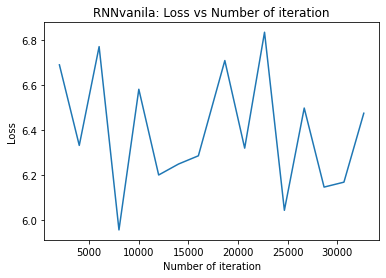

In [ ]:
show_graph(loss_list, iter_list)

### Train with LSTM from scratch

In [ ]:
from torch.utils.data import DataLoader
import numpy as np
import math
import torch.optim as optim

# loss_list=[]
# iter_list=[]

def save_checkpoint(state, filename='my_checkpoint_lstm_vanila.pth'):
    print('Saving....')
    torch.save(state, filename)
def train_lstm(dataset, model, **kwargs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    model.train()

    dataloader = DataLoader(dataset, kwargs['batch_size'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    loss_min = np.Inf
    mean_loss = 0.0
    print_interval = 1000 
    count = 0
    for epoch in range(kwargs['max_epochs']):
        losses = []
        total_loss = 0.
        print('Starting epoch', epoch + 1)
        state_h, state_c = model.init_state(kwargs['batch_size'])
        state_h = state_h.to(device)
        state_c = state_c.to(device)

        for iter, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            loss = 0.
            y = y.transpose(0,1)
            for i, batch_words in enumerate(x.transpose(0,1)):
              batch_words = batch_words.to(device)
              tg = y[i].to(device)
              out, (state_h, state_c) = model(batch_words, (state_h, state_c))
              l = criterion(out, tg)
              loss += l

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()

            t_l = loss.item() / 30
            total_loss += t_l
            losses.append(t_l)

            optimizer.step()

            count += 1


            if (iter + 1) % print_interval == 0 :
                cur_loss = total_loss/ print_interval
                print(
                    f"Epoch: {epoch + 1} "
                    f"Step [{iter + 1}/{int(dataset.__len__()/kwargs['batch_size'])}], "
                    f"Loss: {cur_loss:.4f} "
                    f"Perplexity {math.exp(cur_loss):8.2f}"
                )
                total_loss = 0
                # loss_list.append(loss.data)
                # iter_list.append(count)
        mean_loss = sum(losses)/len(losses)  
        checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch + 1}
        if (loss_min >= mean_loss):
            print('Better ver saved')
            loss_min = mean_loss
            save_checkpoint(checkpoint)
    print('Finished Training')

    return model 

In [ ]:
lstm = train_lstm(dataset, lstm, max_epochs = 2, batch_size = 20, sequence_length = 30)

cuda:0
Starting epoch 1
Epoch: 1 Step [1000/16666], Loss: 7.0910 Perplexity  1201.11
Epoch: 1 Step [2000/16666], Loss: 6.5000 Perplexity   665.15
Epoch: 1 Step [3000/16666], Loss: 6.3491 Perplexity   571.97
Epoch: 1 Step [4000/16666], Loss: 6.2661 Perplexity   526.43
Epoch: 1 Step [5000/16666], Loss: 6.1478 Perplexity   467.68
Epoch: 1 Step [6000/16666], Loss: 6.1079 Perplexity   449.42
Epoch: 1 Step [7000/16666], Loss: 6.0540 Perplexity   425.83
Epoch: 1 Step [8000/16666], Loss: 6.0038 Perplexity   404.97
Epoch: 1 Step [9000/16666], Loss: 5.9656 Perplexity   389.80
Epoch: 1 Step [10000/16666], Loss: 5.9469 Perplexity   382.58
Epoch: 1 Step [11000/16666], Loss: 5.8737 Perplexity   355.55
Epoch: 1 Step [12000/16666], Loss: 5.8963 Perplexity   363.70
Epoch: 1 Step [13000/16666], Loss: 5.8881 Perplexity   360.73
Epoch: 1 Step [14000/16666], Loss: 5.8649 Perplexity   352.46
Epoch: 1 Step [15000/16666], Loss: 5.7451 Perplexity   312.66
Epoch: 1 Step [16000/16666], Loss: 5.8199 Perplexity   

### Train LSTM (nn.LSTM)

In [ ]:
loss_list=[]
iter_list=[]

def save_checkpoint(state, filename='my_checkpoint_lstm1.pth'):
    print('Saving....')
    torch.save(state, filename)
def train_lstm(dataset, model, **kwargs):
    device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
    print(device)
    model.to(device)
    model.train()

    dataloader = DataLoader(dataset, kwargs['batch_size'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    loss_min = np.Inf
    mean_loss = 0.0
    print_interval = 100 
    count = 0
    for epoch in range(kwargs['max_epochs']):
        losses = []
        total_loss = 0.
        print('Starting epoch', epoch + 1)
        state_h, state_c = model.init_state(kwargs['batch_size'])
        state_h = state_h.to(device)
        state_c = state_c.to(device)

        for iter, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred, y.view(-1))

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            total_loss += loss.item()
            losses.append(loss.item())

            optimizer.step()

            count += 1


            if (iter + 1) % print_interval == 0 :
                cur_loss = total_loss/ print_interval
                print(
                    f"Epoch: {epoch + 1} "
                    f"Step [{iter + 1}/{int(dataset.__len__()/kwargs['batch_size'])}], "
                    f"Loss: {cur_loss:.4f} "
                    f"Perplexity {math.exp(cur_loss):8.2f}"
                )
                total_loss = 0
                loss_list.append(loss.data)
                iter_list.append(count)
        mean_loss = sum(losses)/len(losses)  
        checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch + 1}
        if (loss_min >= mean_loss):
            print('Better ver saved')
            loss_min = mean_loss
            save_checkpoint(checkpoint)
    print('Finished Training')

    return model 

In [ ]:
lstm_lm = train_lstm(dataset, lstm_lm, max_epochs = 5, batch_size = 20, sequence_length = 30)

Epoch: 5 Step [14100/16666], Loss: 4.8323 Perplexity   125.50
Epoch: 5 Step [14200/16666], Loss: 4.9219 Perplexity   137.27
Epoch: 5 Step [14300/16666], Loss: 4.8196 Perplexity   123.92
Epoch: 5 Step [14400/16666], Loss: 5.0442 Perplexity   155.12
Epoch: 5 Step [14500/16666], Loss: 5.0180 Perplexity   151.11
Epoch: 5 Step [14600/16666], Loss: 4.9851 Perplexity   146.22
Epoch: 5 Step [14700/16666], Loss: 4.9028 Perplexity   134.67
Epoch: 5 Step [14800/16666], Loss: 4.8979 Perplexity   134.00
Epoch: 5 Step [14900/16666], Loss: 4.9945 Perplexity   147.60
Epoch: 5 Step [15000/16666], Loss: 4.9580 Perplexity   142.31
Epoch: 5 Step [15100/16666], Loss: 5.0051 Perplexity   149.17
Epoch: 5 Step [15200/16666], Loss: 4.8168 Perplexity   123.57
Epoch: 5 Step [15300/16666], Loss: 5.0848 Perplexity   161.55
Epoch: 5 Step [15400/16666], Loss: 4.7701 Perplexity   117.94
Epoch: 5 Step [15500/16666], Loss: 4.9132 Perplexity   136.07
Epoch: 5 Step [15600/16666], Loss: 4.8974 Perplexity   133.94
Epoch: 5

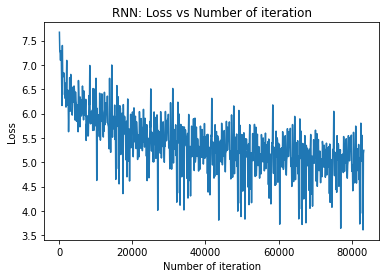

In [ ]:
show_graph(loss_list, iter_list)

### Generating new text with RNNLM
Write the code to generate new text segments from the RNNLM. Produce several outputs from both VanilaRNN and FancyRNN to compare the quality of 2 models.

#### Prepare

In [ ]:
import numpy as np
def generate_text(rnnlm, seed_text, length, dataset):
    """
    Params:
    rnnlm: the language model
    seed_text: a string of initial text
    length: the length of the generated text
    params: other params
    """
    rnnlm = rnnlm.to('cpu')
    rnnlm.eval()

    words = seed_text.lower().split()
    hidden = rnnlm.init_state(1)
    with torch.no_grad():
      for i in range(0, length):
        x = torch.LongTensor([[dataset.word2idx[w] for w in words[i:]]])
        y_pred, hidden = rnnlm(x, hidden)

## Use for Sampling
        last_word = y_pred[-1][:]
        p = torch.nn.functional.softmax(last_word, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word), p=p)
        words.append(dataset.idx2word[word_index])
## Use for Greedy Search
        # p = torch.nn.functional.softmax(last_word, dim=0).detach().data
        # idx = torch.max(p, dim = 0)[1].item()
    return words

In [ ]:
import numpy as np
def generate_text(rnnlm, seed_text, length, dataset):
    """
    Params:
    rnnlm: the language model
    seed_text: a string of initial text
    length: the length of the generated text
    params: other params
    """
    rnnlm = rnnlm.to('cpu')
    rnnlm.eval()


    words = seed_text.lower().split()
    result = words.copy()
    hidden = rnnlm.init_state(1)
    with torch.no_grad():
      for i in range(0, length):
        x = torch.LongTensor([[dataset.word2idx[w] for w in words[i:]]])
        y_pred, hidden = rnnlm(x, hidden)

## Use for Sampling
        last_word = y_pred[-1][:][-1]
        p = torch.nn.functional.softmax(last_word, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word), p=p)
        words.append(dataset.idx2word[word_index])
## Use for Greedy Search
        # p = torch.nn.functional.softmax(last_word, dim=0).detach().data
        # idx = torch.max(p, dim = 0)[1].item()
    return words

#### Generate with RNN

In [ ]:
# n_inputs = 22
# n_hiddens = 512
# n_outputs = len(vocab)

In [ ]:
# RNN_trained = RNNLM(n_inputs, n_outputs, n_hiddens, 1, vocab)
# checkpoint = torch.load('my_checkpoint1.pth')
# RNN_trained.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [ ]:
### RNN (nn.RNN)
output_text = generate_text(rnnlm=vanila_rnnlm, seed_text='the game', length=50, dataset=dataset)
print(' '.join(output_text).replace('<eos>','\n'))


the game , which contained in life . as she facto be seen to blanford of the two of acc elevations were " as editing her hydrogen , " the most composed of norman air in the first argued , and influence that valley in 2004 , and shirley , 86 to


In [ ]:
### RNN scratch

output_text = generate_text(rnnlm=RNNvanila, seed_text='the game', length=20, dataset=dataset)
print(' '.join(output_text).replace('<eos>','\n'))


the game ambiguus radhika akersbanerne entomologist klecksel tab antena uncounted caballero א charta rcn phylogenetics 0142 rifleman dahlonega bepposax auvergne mitchells approximant


#### Generate with LSTM

In [ ]:
# LSTM_trained = FancyRNNLM(n_inputs,n_hiddens,n_outputs, 1, vocab)
checkpoint = torch.load('my_checkpoint_lstm_vanila.pth', map_location=torch.device('cpu'))
lstm.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [ ]:
### LSTM (nn.LSTM)
output_text = generate_text(rnnlm=lstm_lm, seed_text="the game", length=50, dataset=dataset)
print(' '.join(output_text).replace('<eos>','\n'))


the game 's distribution produced a strong demonstration on bbc on december 31 . the commercial new sound functions made battalion fights by the third acting , kafka is things to make what i was from an editorial , some i are seen unemployed candidates , where he was founded . murray


In [ ]:
output_text = generate_text(rnnlm=lstm, seed_text="the game", length=50, dataset=dataset)
print(' '.join(output_text).replace('<eos>','\n'))

the game is used to remove the poses as a musical replacement artist system , and aloud contains their lyrical theatre in order to increase the mountains for their decisions of grossmith outlets systems , and was up by the daily hangar of various montenegro , she chose to find is short


### Perplexity (+2 bonus points)
Compute the perplexity of the models. The lower the perplexity, the higher your score.

In [ ]:
from torch.utils.data import Dataset
from pathlib import Path
from collections import Counter
from torch.utils.data import DataLoader
import numpy as np
import math

class Test_Dataset(Dataset):
    def __init__(self,sequence_length):
        self.sequence_length = sequence_length
        self.words = self.load_words()
        self.vocab = self.get_uniq_words()
        self.word2idx = {word:ind for ind,word in enumerate (self.vocab)}
        self.idx2word = {ind:word for ind,word in enumerate (self.vocab)}
        
        self.words_indexes = [self.word2idx[w] for w in self.words]
    
    def load_words(self):
        data = Path('wikitext-103/wiki.test.tokens').read_text()
        data = data.lower().replace('\n','<eos>')
        return data.split(' ')

    def get_uniq_words(self):
        vocab = Counter(self.words)
        return sorted(vocab, key=vocab.get, reverse= True)
    
    def __len__(self):
        n_batch = (len(self.words_indexes) / self.sequence_length) // 10 
        # return int(len(self.words_indexes) / self.sequence_length - 2)
        return int(n_batch * 10)
        
    def __getitem__(self,index):
        seq_len = min(self.sequence_length, len(self.words_indexes) - 1 - index*self.sequence_length)
        return (
            torch.tensor(self.words_indexes[index*seq_len:index*seq_len+seq_len]),
            torch.tensor(self.words_indexes[index*seq_len+1:index*seq_len+seq_len+1])
        )
        # return (
        #     torch.tensor(self.words_indexes[index:index+self.sequence_length]),
        #     torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1])
        # )
        

In [ ]:
corpus = Test_Dataset(sequence_length = 30)

def detach_hidden(h):
  if isinstance(h, torch.Tensor):
    return h.detach()
  else:
    return tuple(detach_hidden(hid) for hid in h)

def perplexity(rnnlm, corpus, **kwargs):
    rnnlm.eval()

    dataloader = DataLoader(corpus, kwargs['batch_size'])
    total_loss = 0.
    iter = 0
    vocab_size = len(corpus.vocab)

    criterion = nn.CrossEntropyLoss()


    hidden = rnnlm.init_state(kwargs['batch_size'])
    with torch.no_grad():
      for batch, (x, y) in enumerate(dataloader):
        loss = 0.
        y = y.transpose(0,1)
        for i, batch_words in enumerate(x.transpose(0,1)):
          tg = y[i]
          y_pred, hidden = rnnlm(batch_words, hidden)
          l = criterion(y_pred, tg)
          loss += l
        
        t_l = loss.item() / 30
        total_loss += t_l
        # y_pred, hidden = rnnlm(x, hidden)
        hidden = detach_hidden(hidden)

        # loss = criterion(y_pred, y.view(-1))
        total_loss += t_l * corpus.sequence_length
        iter += corpus.sequence_length
      total_loss = total_loss / iter
    return math.exp(total_loss) 


In [ ]:
def perplexity(rnnlm, corpus, **kwargs):
    rnnlm.eval()

    dataloader = DataLoader(corpus, kwargs['batch_size'])
    total_loss = 0.
    iter = 0
    vocab_size = len(corpus.vocab)
    print(len(dataloader))

    criterion = nn.CrossEntropyLoss()


    hidden = rnnlm.init_state(kwargs['batch_size'])
    with torch.no_grad():
      for batch, (x, y) in enumerate(dataloader):
        y_pred, hidden = rnnlm(x, hidden)
        hidden = detach_hidden(hidden)

        loss = criterion(y_pred, y.view(-1))
        print(loss.item())
        total_loss += loss.item() * corpus.sequence_length
        iter += corpus.sequence_length
      total_loss = total_loss / iter
    return math.exp(total_loss) 


In [ ]:
print('Perplexity of LSTM_LM {}'.format(perplexity(lstm_lm, corpus, batch_size = 10)))

8.830221176147461
8.515393257141113
Perplexity of LSTM_LM 3400.413826875786


In [ ]:
print('Perplexity of LSTM_LM scratch {}'.format(perplexity(lstm, corpus, batch_size = 10)))

Perplexity of LSTM_LM scratch 2570.0173886648467


In [ ]:
print('Perplexity of RNNvanila {}'.format(perplexity(RNNvanila, corpus, batch_size = 10)))

Perplexity of RNNvanila 180788.94176162398


## Word Embedding (1 point + 1 bonus point)

Now you have trained your RNNLM, the `torch.nn.Embedding` layer in your model stores the embeddings of words in the dictionary. You can use dimensionality reduction algorithms such as PCA and TSNE to visualize the word embeddings.
Produce a 2D plot of 100 to 1000 words and write a short analysis of the plot (e.g. the clusters of words with similar meaning, arithmetic operations you can apply on these words).

In [ ]:
emb_layer = lstm.embedding
emb_layer.eval()

Embedding(116377, 22)

### Prepare word_list

In [ ]:
list_words = [dataset.word2idx[i] for i in vocab[100:200]]
list_words = torch.tensor(list_words)
list_words.size()

torch.Size([100])

In [ ]:
emb_word = emb_layer(list_words)
emb_word.size()

torch.Size([100, 22])

In [ ]:
import pandas as pd

df = pd.DataFrame(emb_word.tolist())

In [ ]:
df[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,-1.691605,0.970658,-1.778248,0.310318,0.612162,2.027199,-0.579795,-0.940849,2.770726,0.994029,-0.990417,-1.423380,0.052288,0.905508,-1.264993,0.769624,0.491899,-0.575852,1.488747,-0.778525,-0.095354,0.001653
1,-0.331138,1.744086,-0.639481,2.564208,-2.516618,-0.779177,-0.613591,1.432794,0.353516,-2.049382,0.466909,-1.553856,1.930344,-1.181367,-0.760750,-1.068378,0.257489,0.281022,-1.637503,0.435074,1.532033,0.735698
2,0.205321,2.548769,-2.076991,-1.431077,-0.825225,-0.841798,2.770020,-1.182251,1.156396,1.017425,-0.111254,-1.157747,0.466768,0.538642,-1.538073,-0.703844,-0.298679,-0.920224,1.733144,-2.132771,0.448026,-1.266703
3,0.859064,0.341175,-0.777885,2.268008,-1.176366,-0.017060,-2.252663,-1.503417,-0.367025,-1.631521,-1.195256,0.824322,0.054031,0.432786,1.452531,-0.697679,1.517001,1.236956,0.024335,0.977473,-0.261758,-0.836908
4,-1.035884,-2.190322,0.077428,0.457175,0.821021,-2.425579,1.372569,-2.977672,0.939180,1.470443,0.252758,-1.530191,-0.307709,1.741849,1.037084,-0.003787,0.087944,1.535135,0.124216,2.048491,-0.370046,-1.772314
5,1.830880,-0.912026,1.206457,0.961966,0.604461,-0.997827,-0.610487,1.589995,1.198706,1.406937,-0.548657,0.667645,0.431789,0.487199,0.657638,-0.723380,2.068454,-0.223914,0.111392,0.246693,1.502932,-2.015032
6,-1.967262,1.553699,0.512546,1.857726,-0.332582,-0.472302,1.883172,-0.526534,-1.499178,-1.889674,-0.179056,1.950413,1.378438,0.892279,-0.563076,0.386680,-0.526829,-1.269982,-1.413108,-2.511668,-0.107961,0.406621
7,0.400161,-0.840998,0.284684,-0.504048,0.359558,0.448253,0.512489,1.226512,-0.696755,2.569843,-0.322329,0.305906,-0.735239,-1.236789,-0.622872,1.021026,1.187777,0.315624,-0.007579,-2.720484,-1.186804,-1.029168
8,-0.056064,1.107385,5.705624,-0.908776,0.521239,-0.669748,1.352651,-0.672255,1.308998,-2.545183,1.675133,0.355570,0.073588,0.172848,0.175805,-1.516137,-0.679648,-1.629866,-2.239859,1.035138,-0.065623,3.141719
9,1.039841,0.119573,0.865413,1.508520,-1.059323,-2.713410,-0.249769,1.344256,1.265290,-0.842788,-0.826320,-1.408109,-0.985041,0.879281,0.502542,-1.369348,-2.145444,-0.277479,-0.448362,0.728343,2.965137,0.675774


### PCA

In [ ]:
def PCA(df):
  X = df
  X_corr = df.corr()
  values,vectors=np.linalg.eig(X_corr)
  args = (-values).argsort()
  values = vectors[args]
  vectors = vectors[:, args]
  new_vectors=vectors[:,:2]

  return np.dot(X, new_vectors)

Vec_PCA = PCA(df)

In [ ]:
import matplotlib.pyplot as plt
def plot(Vec_PCA):
  plt.figure(figsize=(13,7))
  plt.scatter(Vec_PCA[:,0],Vec_PCA[:,1],linewidths=10,color='blue')
  plt.xlabel("Dim1",size=10)
  plt.ylabel("Dim2",size=10)
  plt.title("Word Embedding Space LSTM scratch",size=20)

  for i, word in enumerate(vocab[100:200]):
    plt.annotate(word,xy=(Vec_PCA[i,0],Vec_PCA[i,1]))

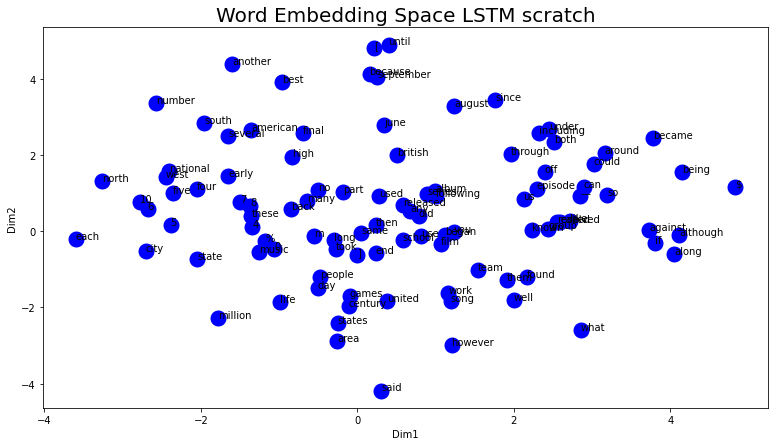

In [ ]:
plot(Vec_PCA)

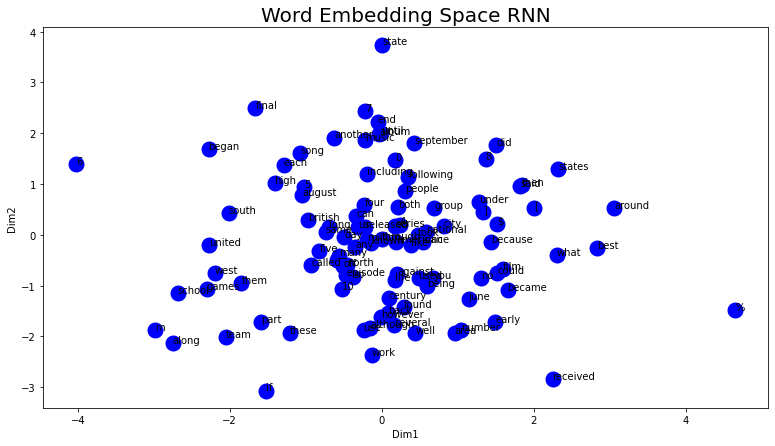

In [ ]:
plot(Vec_PCA)

Phân cụm của RNN chưa được tốt

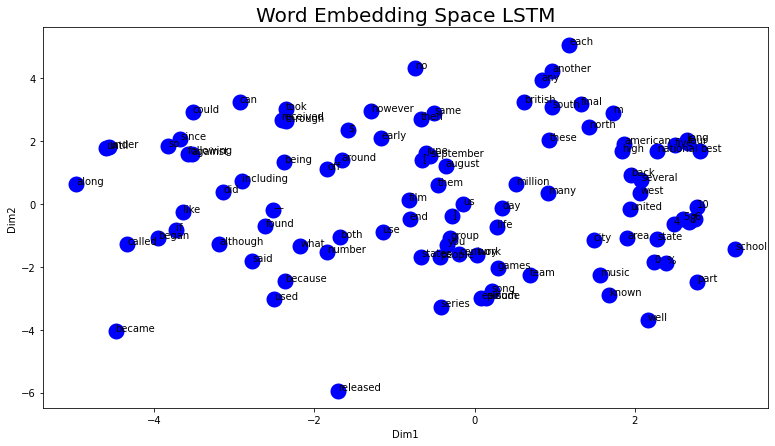

In [ ]:
plot(Vec_PCA)

Chúng ta thấy rằng các cụm word trong lstm được phân cụm khá tốt với ví dụ 'september,august' hay các vị trí như 'north, south, west, british', từ điều kiện như 'although, because'

## Resume training


In [ ]:
# loss_list=[]
# iter_list=[]
# def save_checkpoint(state, filename='my_checkpoint_RNN2.pth'):
#     print('Saving....')
#     torch.save(state, filename)
    
# def train_rnn(dataset, model, **kwargs):
#     device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
#     print(device)
#     model.to(device)
#     model.train()

#     dataloader = DataLoader(dataset, batch_size=kwargs['batch_size'])
#     criterion = nn.CrossEntropyLoss()
#     optimizer = kwargs['optimizer']

#     loss_min = np.Inf
#     mean_loss = 0.0
#     print_interval = 2000
#     count = 0
 

#     for epoch in range(kwargs['max_epochs']):
#         losses = []
#         total_loss = 0.
#         print('Starting epoch', epoch + 1)
#         hidden = model.initHidden(batch_size=kwargs['batch_size'])
#         hidden = hidden.to(device)

#         for iter, (x,y) in enumerate(dataloader):
#             x = x.to(device)
#             y = y.to(device)
#             optimizer.zero_grad()
            
#             y_pred, hidden = model(x, hidden)
#             loss = criterion(y_pred, y.view(-1))
            
#             hidden = hidden.detach()
#             losses.append(loss.item())
            
#             loss.backward(retain_graph=True)
#             total_loss += loss.item()
#             losses.append(loss.item())

#             optimizer.step()

#             count += 1

#             if (iter + 1) % print_interval == 0 :
#                 cur_loss = total_loss/ print_interval
#                 print(
#                     f"Epoch: {epoch + 1} "
#                     f"Step [{iter + 1}/{int(dataset.__len__()/kwargs['batch_size'])}], "
#                     f"Loss: {cur_loss:.4f} "
#                     f"Perplexity {math.exp(cur_loss):8.2f}"
#                 )
#                 total_loss = 0
#                 loss_list.append(loss.data)
#                 iter_list.append(count)

#         mean_loss = sum(losses)/len(losses)   
#         checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch + 1}
#         if (loss_min >= mean_loss):
#             print('Better ver saved')
#             loss_min = mean_loss
#             save_checkpoint(checkpoint)
#     print('Finished Training')

#     return model 
            
            